<font size="6"><b>Modelling</b></font>

<br>
<font size="3"><b>Import libraries</b></font>

In [1]:
# sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, recall_score, confusion_matrix

# xgboost
from xgboost import XGBClassifier

# nltk
from nltk import FreqDist

# utilities
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# preferences
pd.set_option('display.max_columns', None)
%matplotlib inline

<br>
<font size="3"><b>Read in dataset and display column and datatype info</b></font>
<br>
Dataset preprocessed via data_processing.ipynb

In [2]:
# read tsv dataset into pandas df
filename = 'amazon_reviews_us_Luggage_v1_00'

cols = ['TARGET',  #<---ratio of helpful votes to total votes above/below median 
        'STEM',     #<---lemmas or stemmas ['LEM' or 'STEM']
        'CHAR',    #<---number of characters
        'NUM',     #<---number of tokens
        'WORD',    #<---number of words
        'LEN',     #<---average sentence length
        'SENT',    #<---number of sentences
        'AVG',     #<---sentence length
        'INTERRO', #<---number of questionss
        'PER',     #<---percent questions
        'EXCLAM',  #<---number of exclamations
        'COUNT',   #<---number of exclamation points
        'CAPS',    #<---percentage of capitalized characters
        'MED',     #<---product's median star rating
        'FAV',     #<---reviewer's rating vs product's media
        'POP']     #<---number of product's review

df = pd.read_csv(f'data/{filename}_processed.csv',
                 usecols = cols)                

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12132 entries, 0 to 12131
Data columns (total 16 columns):
TARGET     12132 non-null int64
STEM       12132 non-null object
CHAR       12132 non-null int64
NUM        12132 non-null int64
WORD       12132 non-null int64
LEN        12132 non-null float64
SENT       12132 non-null int64
AVG        12132 non-null float64
INTERRO    12132 non-null int64
PER        12132 non-null float64
EXCLAM     12132 non-null int64
COUNT      12132 non-null int64
CAPS       12132 non-null float64
MED        12132 non-null float64
FAV        12132 non-null float64
POP        12132 non-null int64
dtypes: float64(6), int64(9), object(1)
memory usage: 1.5+ MB


<br>
<font size="3"><b>Preview dataframe</b></font>

In [4]:
df.head(3)

,TARGET,STEM,CHAR,NUM,WORD,LEN,SENT,AVG,INTERRO,PER,EXCLAM,COUNT,CAPS,MED,FAV,POP
0,0,"['strap', 'broke', 'suppos', 'anti', 'theft', ...",318,25,63,5.047619,6,10.500000,1,0.166667,2,3,0.031447,4.0,-3.0,15
1,0,"['product', 'absolut', 'beauti', 'order', 'lar...",437,39,80,5.462500,9,8.888889,1,0.111111,1,2,0.048055,5.0,0.0,1
2,0,"['review', 'iblu', 'overs', 'leather', 'canva'...",1951,193,351,5.558405,15,23.400000,1,0.066667,6,9,0.033316,5.0,0.0,1


<br>
<font size="4"><b>Step 1:</b> Combine TF-IDF vectors with extracted features and split train and test sets</font>

In [5]:
# set X to df and drop TARGET, set y to TARGET, and split train and test sets (80/20)
X = df.drop(columns=['TARGET'])
y = df.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [6]:
# vectorize and drop LEM or STEM 
vectorizer = TfidfVectorizer(ngram_range=(1, 2),    #<--- compare unigrams and bigrams
                             max_df=.9, min_df=.1)  #<--- drop top/bottom 10% most common tokens

tfidf_train = vectorizer.fit_transform(X_train.STEM) #<---df.LEM or df.STEM
tfidf_test = vectorizer.transform(X_test.STEM)       #<---df.LEM or df.STEM

X_train = X_train.drop(columns=['STEM'])             #<---df.LEM or df.STEM
X_test = X_test.drop(columns=['STEM'])               #<---df.LEM or df.STEM

# check tfidf sparsity
print(
    f"Average number of NON-ZERO elements per vectorized review: {tfidf_train.nnz / float(tfidf_train.shape[0])}"
)

Average number of NON-ZERO elements per vectorized review: 19.44183410613086


In [7]:
# convert tfidf to array and concatenate train and test sets
X_train = pd.concat([pd.DataFrame(tfidf_train.toarray()), X_train.reset_index()], axis = 1)
X_test = pd.concat([pd.DataFrame(tfidf_test.toarray()), X_test.reset_index()], axis = 1)

<br>
<font size="4"><b>Step 2:</b> Optimize random forest and XGBoost classifiers with gridsearch</font>

In [8]:
"""UNCOMMENT BELOW TO RUN RANDOM FOREST GRID SEARCH"""
# # create dictionary of parameters to tune
# param_grid = {'n_estimators': [100, 500],
#               'criterion': ['gini', 'entropy'],
#               'max_depth': [None, 2, 10],
#               'max_features': [None, 4, 16, 24]}

# # create grid search object and fit to data
# grid_forest = GridSearchCV(RandomForestClassifier(random_state=42),
#                            param_grid,
#                            cv=2,
#                            scoring='f1',
#                            verbose=1,
#                            n_jobs=16)

# grid_forest.fit(X_train, y_train)

# # pickle grid parameters
# pickle_out = open("rf_grid.pickle","wb")
# pickle.dump(grid_forest, pickle_out)
# pickle_out.close()

'UNCOMMENT BELOW TO RUN RANDOM FOREST GRID SEARCH'

In [9]:
"""UNCOMMENT BELOW TO RUN XGBOOST GRID SEARCH"""
# # create dictionary of parameters to tune
# param_grid = {'learning_rate': [0.1, 0.2],
#               'max_depth': [6],
#               'min_child_weight': [1, 2],
#               'subsample': [0.5, 0.7],
#               'n_estimators': [100]}


# # create grid search object and fit to data
# grid_boost = GridSearchCV(XGBClassifier(random_state=42),
#                            param_grid,
#                            cv=2,
#                            scoring='f1',
#                            verbose=1,
#                            n_jobs=16)

# grid_boost.fit(X_train, y_train)

# # pickle grid parameters
# pickle_out = open("xgb_grid.pickle","wb")
# pickle.dump(grid_boost, pickle_out)
# pickle_out.close()

'UNCOMMENT BELOW TO RUN XGBOOST GRID SEARCH'

In [10]:
# load grid parameters
grid_forest = pd.read_pickle('rf_grid.pickle')
grid_boost = pd.read_pickle('xgb_grid.pickle')

print(grid_forest.best_params_['criterion'],
      grid_forest.best_params_['max_depth'],
      grid_forest.best_params_['max_features'],
      grid_forest.best_params_['n_estimators'])

print(grid_boost.best_params_['learning_rate'],
      grid_boost.best_params_['max_depth'],
      grid_boost.best_params_['min_child_weight'],
      grid_boost.best_params_['subsample'],
      grid_boost.best_params_['n_estimators'])

entropy 2 None 500
0.1 6 1 0.7 100


<br>
<font size="4"><b>Step 3:</b> Fit and predict on classifiers</font>

In [11]:
# instantiate random forest classifier
rf_classifier = RandomForestClassifier(criterion = grid_forest.best_params_['criterion'],
                                       max_depth = grid_forest.best_params_['max_depth'],
                                       max_features = grid_forest.best_params_['max_features'],
                                       n_estimators = grid_forest.best_params_['n_estimators'],
                                       random_state = 42)

# instantiate xgboost classifier
xgb_classifier = XGBClassifier(learning_rate = grid_boost.best_params_['learning_rate'],
                               max_depth = grid_boost.best_params_['max_depth'],
                               max_child_weight = grid_boost.best_params_['min_child_weight'],
                               subsample = grid_boost.best_params_['subsample'],
                               n_estimators = grid_boost.best_params_['n_estimators'],
                               random_state = 42)

In [12]:
# fit and predict on random forest classifier
rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

# fit and predict on xgboost classifier
xgb_classifier.fit(X_train, y_train)
xgb_train_preds = xgb_classifier.predict(X_train)
xgb_test_preds = xgb_classifier.predict(X_test)

<br>
<font size="3"><b>Evaluate models</b></font>

In [13]:
# random forest metrics
print('Random Forest')
print(f"Training Accuracy: {accuracy_score(y_train, rf_train_preds):.4}",
      f"Testing Accuracy: {accuracy_score(y_test, rf_test_preds):.4}")

print(f"Training Recall: {recall_score(y_train, rf_train_preds):.4}",
      f"Testing Recall: {recall_score(y_test, rf_test_preds):.4}")

print(f"Training F1: {f1_score(y_train, rf_train_preds):.4}",
      f"Testing F1: {f1_score(y_test, rf_test_preds):.4}")

# xgboost metrics
print('XGBoost')
print(f"Training Accuracy: {accuracy_score(y_train, xgb_train_preds):.4}",
      f"Testing Accuracy: {accuracy_score(y_test, xgb_test_preds):.4}")

print(f"Training Recall: {recall_score(y_train, xgb_train_preds):.4}",
      f"Testing Recall: {recall_score(y_test, xgb_test_preds):.4}")

print(f"Training F1: {f1_score(y_train, xgb_train_preds):.4}",
      f"Testing F1: {f1_score(y_test, xgb_test_preds):.4}")


Random Forest
Training Accuracy: 0.6013 Testing Accuracy: 0.604
Training Recall: 0.7055 Testing Recall: 0.6951
Training F1: 0.6365 Testing F1: 0.6383
XGBoost
Training Accuracy: 0.837 Testing Accuracy: 0.6135
Training Recall: 0.8415 Testing Recall: 0.6049
Training F1: 0.8363 Testing F1: 0.6114


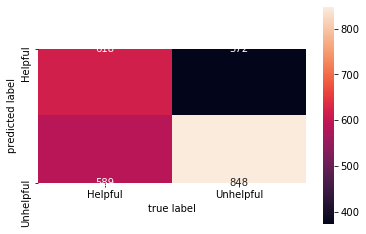

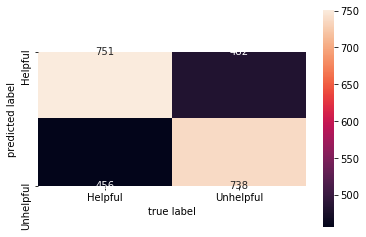

In [14]:
# random forest confusion matrix
mat = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(mat.T,
            square=True,
            annot=True,
            fmt='d',
            cbar=True,
            xticklabels=['Helpful', 'Unhelpful'],
            yticklabels=['Helpful', 'Unhelpful'])

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

# xgboost confusion matrix
mat = confusion_matrix(y_test, xgb_test_preds)
sns.heatmap(mat.T,
            square=True,
            annot=True,
            fmt='d',
            cbar=True,
            xticklabels=['Helpful', 'Unhelpful'],
            yticklabels=['Helpful', 'Unhelpful'])

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()